### CH15. Sequence Data Analysis with CNN + RNN - 2 (Long Sequence)

In [1]:
import tensorflow as tf
import numpy as np
import tensorflow.keras.layers as layer
import tensorflow.keras as keras

- 짧은 시퀀스 데이터는 충분히 SimpleRNN layer만으로도 sequence-to-sequence와 sequence-to-vector모두 예측이 가능하다.
- 그러나 길어지게 되면 많은 타임 스텝에 걸쳐 실행을 해야 할텐데 그렇게 되면 매우 깊은 RNN이 된다.
   - 따라서 gradient loss나 폭주 문제가 발생 할 수도 있고
   - RNN이 긴 시퀀스를 처리할 때 입력의 첫부분을 잊을 확률이 높다.
- 이러한 문제들을 해결하기 위한 방법을 알아보고자 한다.   

#### 1. Gradient 문제 다루기
1. 앞에서 DNN, CNN에서 사용했던 불안정한 gradient를 해결하기 위해 사용했던 방법들은 RNN에서도 사용할 수 있다.
    - 예를 들면 좋은 가중치로 초기화, 빠른 optimizer의 사용, dropout등이 존재한다.
    - 그러나 relu와 같이 tanh대신에 수렴하지 않는 활성화 함수를 사용하는 것은 오히려 문제를 악화시킬수도 있다.
    - 이유는 경사 하강법이 출력을 조금씩 증가시키는 방향으로 가중치를 업데이트 할 때에 **동일한 가중치가 모든 타임 스텝에 적용**되기 때문에 계속해서 timestep들의 출력이 조금씩 증가해 출력이 폭주하고 수렴하지 않는 activation function은 이를 막을 수 없기 때문이다.
        - 그래서 activation 함수를 바꾸기 보다는 gradient clipping을 사용하는 것이 좋다.
2. BatchNormalization 또한 맞는 방법은 아니기 때문에 Layer Noramlization이라는 방법을 사용한다.
    - 이는 배치 차원에 대해 정규화하지 않고 차원에 대해 정규화 한다.
    - 입력마다 하나의 scale과 이동 parameter을 학습한다.
    - RNN에서 이 정규화는 일반적으로 입력과 선형 조합 직후에 사용이 된다.
-Layer Normalization-
1. 입력값으로 현재 timestep의 상태인 X(t)와 이전 출력값인 H(t-1)을 받는다.
2. 이전 출력값, 즉 states는 하나 이상의 tensor을 담은 list이다.
3. 이번에는 SimpleRNN처럼 작동하도록 구현할 것이기 때문에 input_dim과 output_dim, 즉 unit의 개수가 동일할 것이다.
    

In [15]:
class LayerNormalizationRNNcell(tf.keras.layers.Layer):
    def __init__(self, units, activation = 'tanh',**kwargs):
        super(LayerNormalizationRNNcell, self).__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        #활성화 함수 없이 SimpleRNNCell을 만드는 이유는 미리 layer normalization을 진행하기 위해서이다.
        #여기서 주의 할 점은 하나의 RNN Cell을 만든다는 것이다.
        #SimpleRNN은 timestep전체를 진행하지만 이는 한번의 step만 진행한다.
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(activation = None, units = units)
        self.layer_norm = tf.keras.layers.LayerNormalization()
        self.activation = tf.keras.activations.get(activation)
    
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        #이전 출력과 현재 입력의 선형 조합을 계산하고 정규화를 한 뒤에 activation함수에 넣는다.
        norm_outputs = self.activation(self.layer_norm(outputs))
        #출력을 두번 반환하는 이유는 전자는 출력, 후자는 list에 담긴 새로운 은닉 상태이어야 하기 때문이다.
        return norm_outputs, [norm_outputs]

In [16]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.RNN(LayerNormalizationRNNcell(20), input_shape = [None,1], return_sequences = True))
model.add(tf.keras.layers.RNN(LayerNormalizationRNNcell(20), return_sequences = True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10)))

In [21]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_5 (RNN)                  (None, None, 20)          480       
_________________________________________________________________
rnn_6 (RNN)                  (None, None, 20)          860       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 10)          210       
Total params: 1,550
Trainable params: 1,550
Non-trainable params: 0
_________________________________________________________________


- 위의 layer normalization 말고도 dropout을 각 timestpe마다 입력값에 적용하는 dropout도 존재한다.
- 물론 keras에서 이 기능을, 모든 순환층에서 dropout 매개변수 또는 recurrent_dropout 매개변수를 설정할 수 있도록 하기 떄문에 기능이 제공되지만 직접 layer을 만들어 보고 싶어서 사용자 정의 RNNcell을 만들어 보았다.
- 보면 알겠지만 dropout에 의해 param의 개수가 위의 model에 비해 줄었다.

In [18]:
class DropoutRNNcell(tf.keras.layers.Layer):
    def __init__(self, units, activation = 'tanh', **kwargs):
        super(DropoutRNNcell, self).__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = tf.keras.layers.SimpleRNNCell(activation = activation, units = units)
        self.dropout = tf.keras.layers.Dropout(0.3)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        outputs = self.dropout(outputs)
        return outputs, [outputs]
    

In [19]:
drop_model = tf.keras.models.Sequential()
drop_model.add(tf.keras.layers.RNN(DropoutRNNcell(20), input_shape = [None,1], return_sequences = True))
drop_model.add(tf.keras.layers.RNN(DropoutRNNcell(20), return_sequences = True))
drop_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10)))

In [20]:
drop_model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rnn_7 (RNN)                  (None, None, 20)          440       
_________________________________________________________________
rnn_8 (RNN)                  (None, None, 20)          820       
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 10)          210       
Total params: 1,470
Trainable params: 1,470
Non-trainable params: 0
_________________________________________________________________


#### 2. 단기 기억 문제 해결하기
#### LSTM Cell (Long Short-Term Memory)
1. 구조
    - 장기 상태인 C(t)와 단기 상태인 H(t)를 모두 이용한다.
    - 핵심 아이디어는 네트워크가 장기 상태에 저장할 것, 버릴 것, 그리고 읽어들일 것을 학습하는 것이다.
    - 장기 기억은 네트워크를 왼쪽에서 오른쪽으로 관통하면서 삭제 게이트를 지나 일부 기억을 잃고 덧셈 연산으로 새로운 기억을 일부 주입한다. 이후 이 장기 기억은 추가 변환업이 바로 출력으로 보내지게 된다.
        - 따라서 매 timestep마다 일부 기억이 삭제되고 일부 기억이 새롭게 추가가 된다.
        - 또한 이 장기기억은 복사되어 tanh로 전달되어 일부가 걸러져 단기기억이 되어 마찬가지로 출력이 된다.
            - 이 단기기억이 셀의 출력 Y(t)와 동일하다.
        
    1. 입력게이트
        - LSTM cell이 중요한 입력을 인식하도록 한다
    2. 삭제 게이트
        - 장기 상태 저장
        - 필요한 기간동안 이를 보관하도 필요할 때 마다 추출

2. 기울기의 흐름
    - 기존의 RNN layer의 흐름을 볼 때에 기울기 소실/기울기 폭주가 발생하기 쉽다.
    - 그러나 LSTM의 경우에는 '행렬 곱'이 아닌 '원소별 곱'이 이뤄지고, 매 시각 다른 게이트의 값을 이용해서 원소별 곱을 계산한다.
    - 따라서 매번 새로운 게이트의 값을 사용하기 때문에 곱셈의 효과가 누적되지 않아 기울기 소실이 발생하지 않는 것이다.
    - 기억 셀, 즉 장기 기억을 출력하는 셀에는 +연산과 X연산을 모두 수행하는데, +는 상류에서 전해지는 기울기를 그대로 적용하게 되고 X연산의 경우에 위와 같은 이유 때문에 기울기 변화가 발생하지 않는다.
    - X연산은 forget, 즉 삭제 게이트가 제어하는데 이는 매 시각 다른 게이트의 값을 출력하고 삭제 게이트가 '잊어야 한다'고 쓸데 없다고 판단한 데이터에 대한 기울기가 작아지게 되고 저장해야 한다고 판단한 데이터는 반대의 작용이 발생한다.
        - 이러한 이유로 기억 셀이 장기 의존 관계를 유지(학습)하는 것이 가능하다고 판단 할 수 있는 것이다.
           - 따라서 파이썬을 이용해서 이 과정이 어떻게 진행되는 지 코드를 짜보고자 한다.

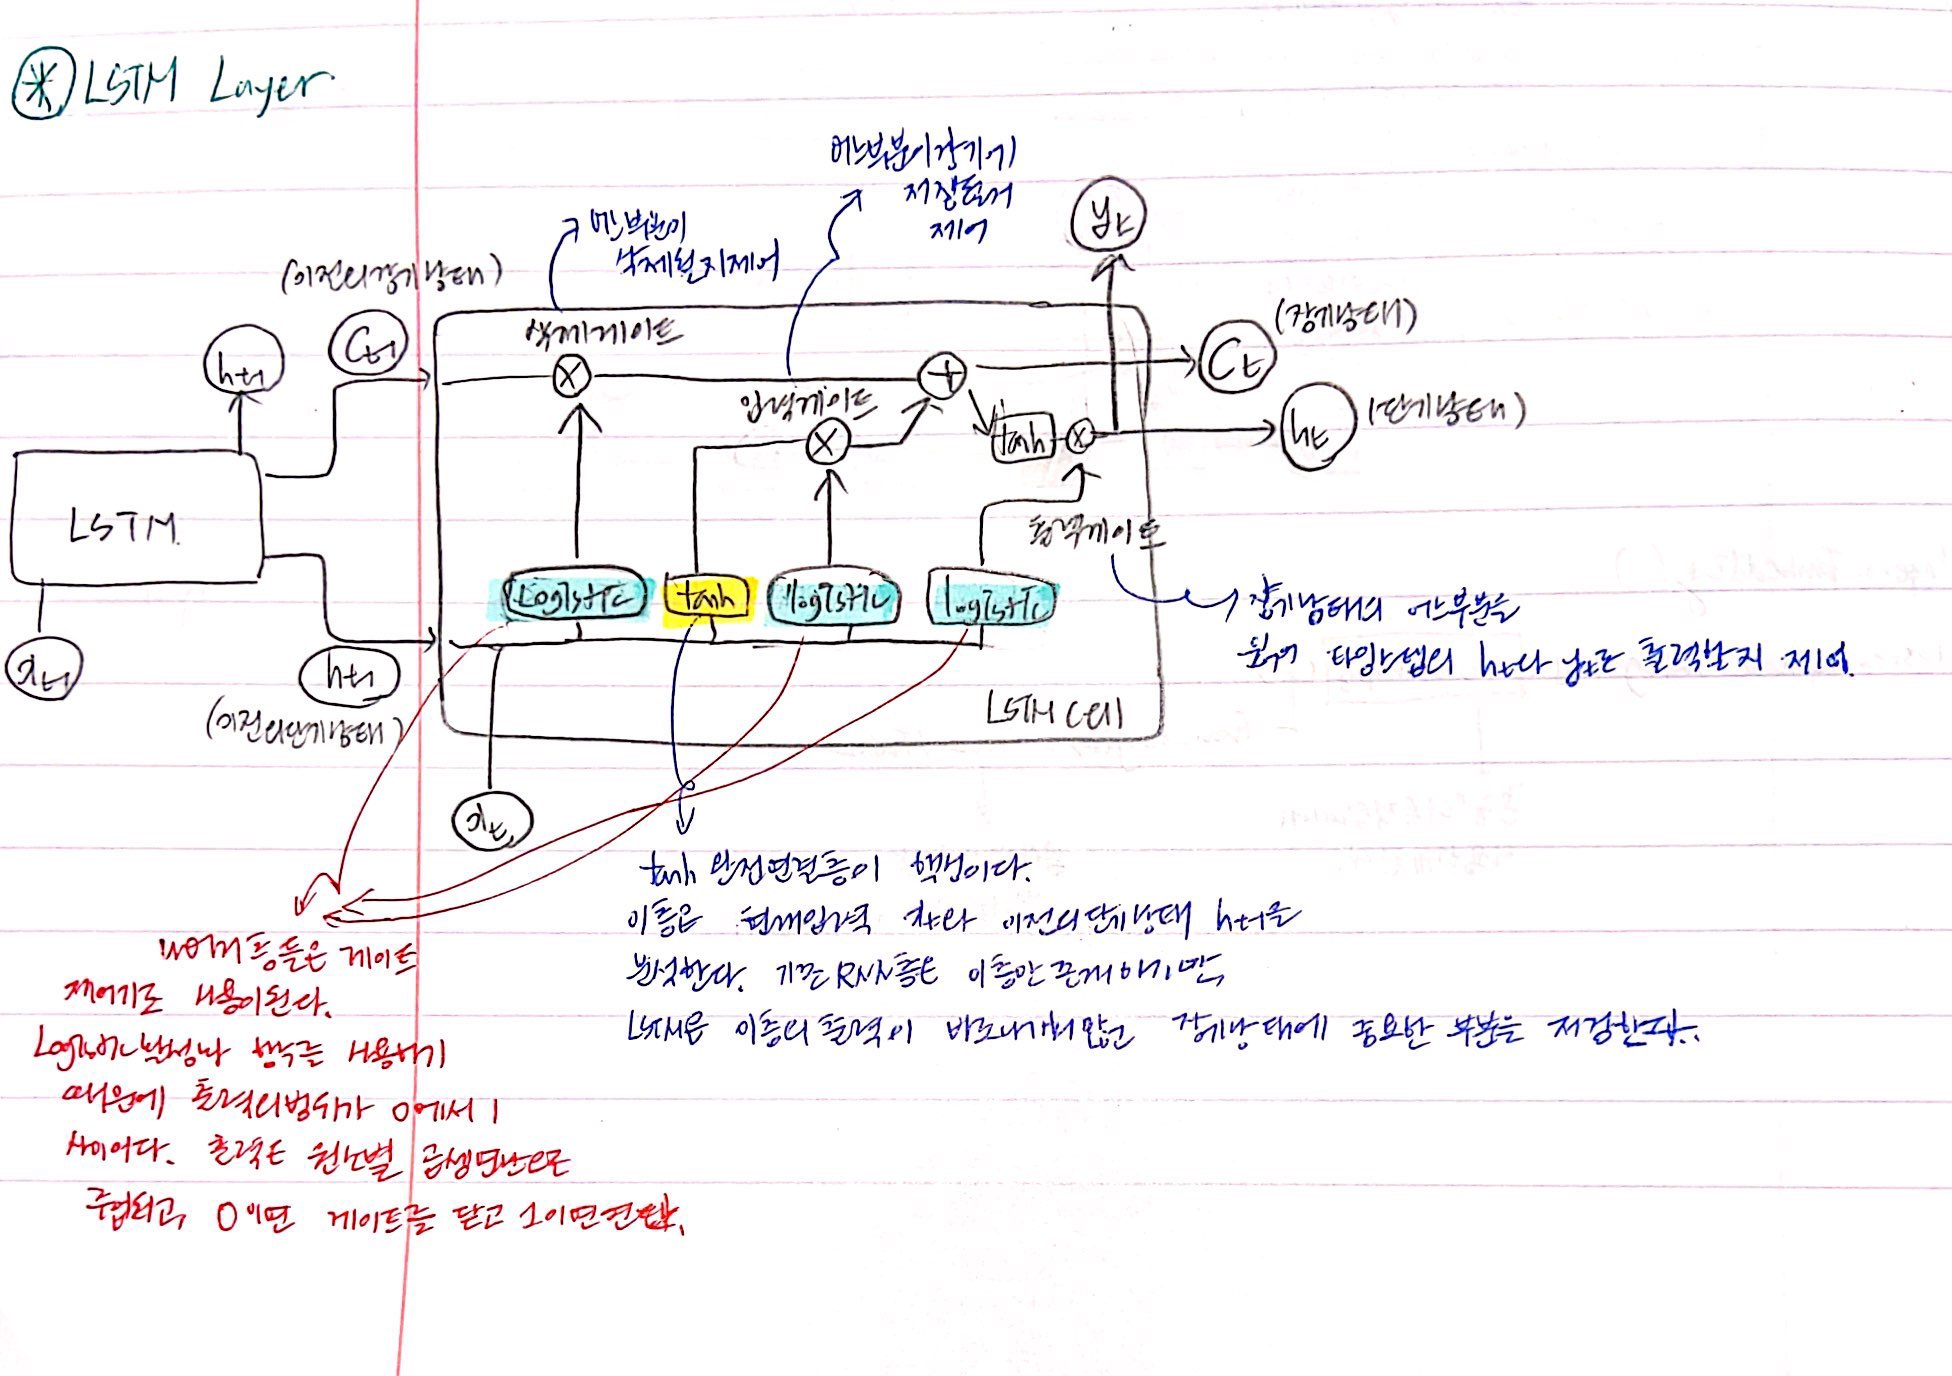

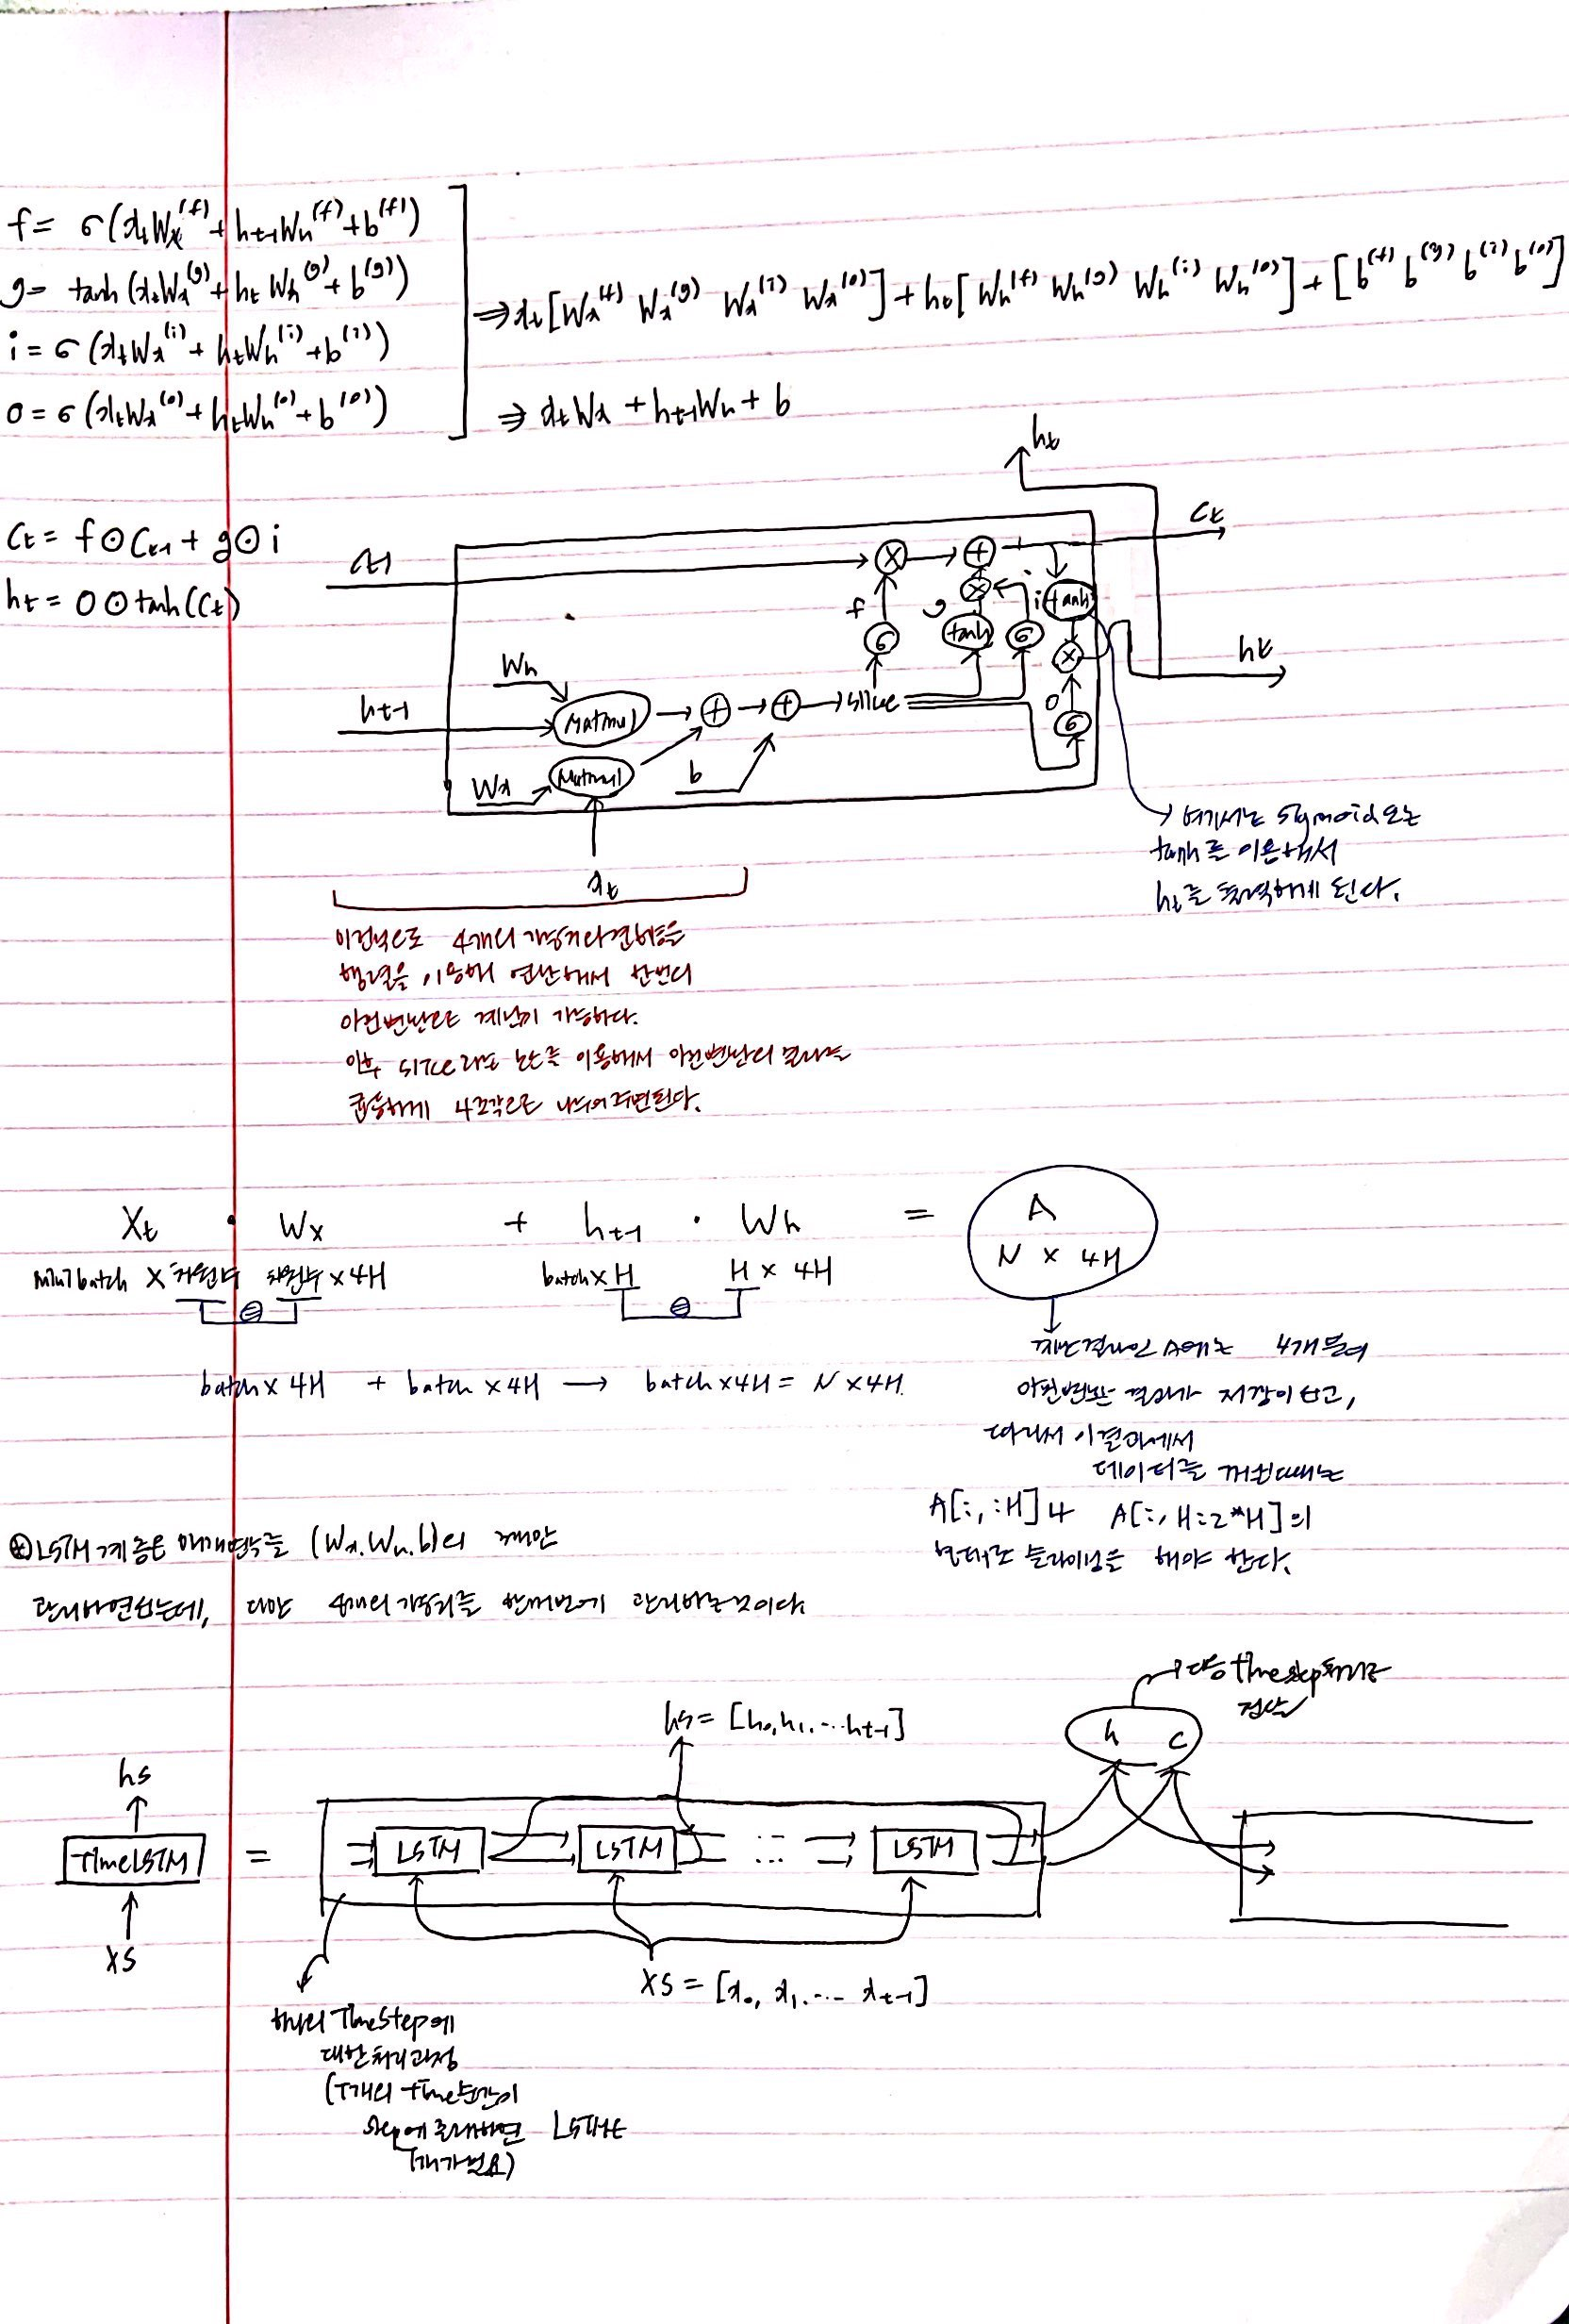

In [2]:
import numpy as np
Wx = [1,2,3]
np.zeros_like(Wx)

array([0, 0, 0])

In [8]:
class LSTM:
    def __init__(self, Wx, Wh, b):
        self.params = [Wx,Wh,b]
        #np.zeros_like()로 하면 괄호 안의 벡터와 같은 크기로 0으로만 구성된 행렬을 반환해 준다.
        #단, 편향 데이터는 1로 채워진 벡터로 초기화해서 훈련 초기에 모든 것이 망각되는 것을 방지한다.
        #아래는 gradient 값의 초기화를 한 것이다.
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        #cache는 순전파 실행 당시에 중간 결과를 보관했다가 역전파 계산에 이용하려는 용도의 인스턴트 변수이다.
        self.cache = None
    
    def forward(self,x, h_prev, c_prev):
        #입력받는 인수는 x는 현 시각의 입력, h_prev는 이전 시각의 은닉 상태, c_prev는 이전 시각의 기억 셀이다.
        Wx, Wh, b = self.params
        N, H = h_prev.shape
        
        A = np.matmul(x, Wx) + np.matmul(h_prev, Wh)
        
        f = A[:,:H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:4*H]
        
        #삭제 게이트 f
        f = sigmoid(f)
        #가장 중요한 정보를 저장하는 게이트 g
        g = np.tanh(g)
        #입력 게이트 i
        i = sigmoid(i)
        #출력 게이트 o
        o = sigmoid(o)
        
        c_next = f * c_prev + g * i
        h_next = o * np.tanh(c_next)
        
        self.cache = (x, h_prev, c_prev, i, f, g, 0, c_next)
        return c_next, h_next

In [10]:
class TimeLSTM:
    def __init__(self, Wx, Wh, b, stateful = False):
        self.params = [Wx, Wh, b]
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        self.layers = None
        self.h, self.c = None, None
        self.df = None
        self.stateful = stateful
    
    def forward(self, xs):
        Wx, Wh, b = self.params
        N, T, D = xs.shape
        H = Wh.shape[0]
        
        self.layers = []
        hs = np.empty((N,T,H), dtype = 'f')
        
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype = 'f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype = 'f')
            
        for i in range(T):
            layer = LSTM(*self.params)
            self.h, self.c = layer.forward(xs[:, :i], self.h, self.c)
            hs[:, i, :] = self.h
            
            self.layers.append(layer)
            
        return hs
    
    def backward(self, dhs):
        Wx, Wh, b = self.params
        N, T, D = dhs.shape
        D = Wx.shape[0]
        
        dxs = np.empty((N, T, D), dtype = 'f')
        dh, dc = 0,0
        
        #3개의 parameter인 x, h, b의 값에 대한 gradient를 생각한다.
        grads = [0,0,0]
        #역전파 이므로 뒤에서부터 계산
        for i in range(T-1, -1,-1):
            layer = self.layers[i]
            dx, dh, b = layer.backward(dhs[:, i, :] + dh, dc)
            dxs[:,i,:] = dx
            #층의 gradinet값을 계속 저장하고 더해준다.
            for j, grad in enumerate(layer.grads):
                grads[j] += grad
        #총 더한 값을 self의 gradient layer을 갱신하는데에 사용한다.
        for i, grad in enumerate(grads):
            self.grads[i] = grad
            self.dh = dh
            return dxs
        
    #우리는 연속으로 하나의 timestep을 예측하는데에 있어서 다음 시간 순간을 예측하고자 할 떄 다음 LSTM layer의 입장에서 생각해보면
    #은닉층의 값만 받는 것이나 마찬가지이다. 따라서 기억셀 c는 외부에서는 보이지 않아서 그 존재 자체를 생각할 필요가 없다.
    def set_state(self, h, c = None):
        self.h, self.c = h,c
    
    def reset_state(self):
        self.h, self.c = None, None
        
        
        
        

In [23]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units = 20, return_sequences = True, input_shape = [None, 1]))
model.add(tf.keras.layers.LSTM(units = 20, return_sequences = True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10)))

In [24]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, None, 20)          1760      
_________________________________________________________________
lstm_3 (LSTM)                (None, None, 20)          3280      
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 10)          210       
Total params: 5,250
Trainable params: 5,250
Non-trainable params: 0
_________________________________________________________________


2. GRU (Gated Recurrent Unit) Cell
- GRU는 LSTM과 비슷하지만, forget gate와 input gate가 upadate gate로 합쳐져서 게이트가 한개 줄었으며
- 기억셀이 존재하지 않고 은닉상태만 시간 방향으로 전파가 된다는 차이가 존재한다.
    - 따라서 LSTM보다 계산 비용을 줄이고 매개변수의 수도 줄였기 때문애 **데이터셋이 작거나 모델 설계시 반복 시도를 많이 해야 할 경우** 사용하는 것이 좋다.
    
- 다만 1D합성곱 층을 추가하면 훨씬 성능이 좋아진다.
- 몇개의 터널을 시퀀스 위를 sliding해서 각각의 kernel마다 1D크기의 특성 맵을 출력한다. 이때 각 kernel은 매우 짧은 하나의 순차 패턴을 감지하도록 학습이 된다. 
    - 만약에 10개의 kernel을 이용한다면 이 층의 출력은 10개의 1차원 sequence가 되어서 출력 자체를 10차원 sequence하나로 볼 수 있다.  
    
    - 아무래도 1D합성곱 층을 사용하게 되면 출력 seqence의 길이를 입력 sequence의 길이보다 줄일 수 있다는 장점이 있다. 
        - kernel_size가 4라면 target에서 처음 3개의 timestep을 버릴 수 있게 된다.
        - 그리고 padding을 'same'이 아닌 'valid'로 설정하면 downsampling이 가능하다.
- 이렇게 합성곱 신경망으로 시퀀스의 길이를 줄이면 GRU나 LSTM으로 하여금 더 긴 패턴을 감지하는데 도움을 줄 수 있다.        

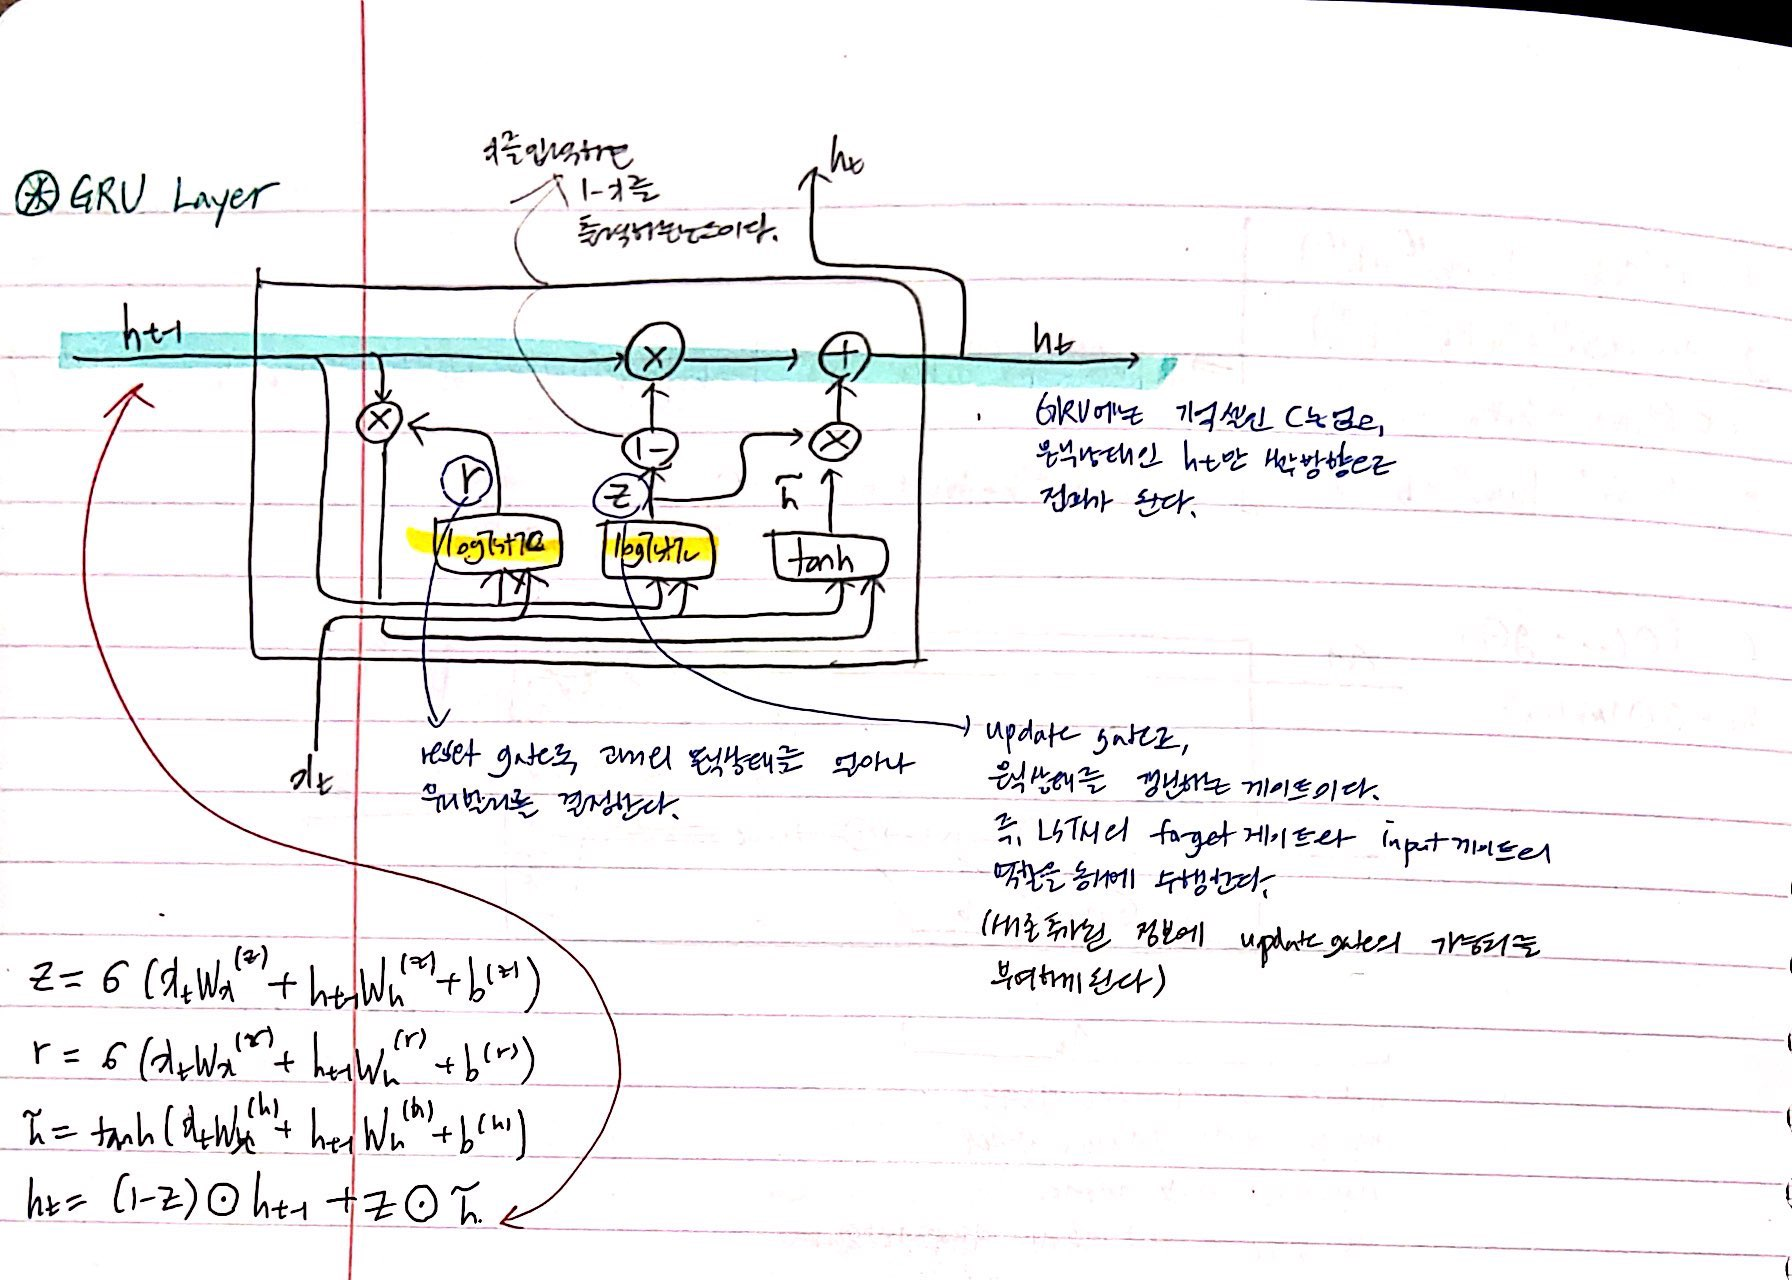

In [25]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Conv1D(filters = 20, kernel_size = 4, strides = 2, padding = 'valid', input_shape = [None, 1]))
model.add(tf.keras.layers.GRU(20, return_sequences = True))
model.add(tf.keras.layers.GRU(20, return_sequences = True))
model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(10)))

In [28]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, None, 20)          100       
_________________________________________________________________
gru (GRU)                    (None, None, 20)          2520      
_________________________________________________________________
gru_1 (GRU)                  (None, None, 20)          2520      
_________________________________________________________________
time_distributed_4 (TimeDist (None, None, 10)          210       
Total params: 5,350
Trainable params: 5,350
Non-trainable params: 0
_________________________________________________________________


In [30]:
def generate_time_series(batch_size, n_steps):
    f1, f2,off1,off2 = np.random.rand(4,batch_size,1)
    time = np.linspace(0,1,n_steps)
    series = 0.5*np.sin((time-off1)*(f1*10 +10))
    series += 0.2 * np.sin((time-off2)*(f2*20+20))
    series += 0.1*(np.random.rand(batch_size, n_steps)-0.5)
    return series[:,:,np.newaxis].astype(np.float32)

In [35]:
n_steps = 50
series = generate_time_series(10000, n_steps + 10)
x_train, y_train = series[:7000, :n_steps], series[:7000, n_steps:,0]
x_val, y_val = series[7000:9000, :n_steps], series[7000:9000, n_steps:,0]
x_test, y_test = series[9000:, :n_steps], series[9000:, n_steps:,0]

In [40]:
y = np.empty((10000, n_steps, 10))
for i in range(1, 10+1):
    y[:,:,i-1] = series[:, i:i+n_steps,0]
y_train = y[:7000]
y_val = y[7000:9000]
y_test = y[9000:]

In [41]:
x_train.shape, y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [42]:
#마지막 출력값의 오차만 계산하기 위해 손실함수 정의
def last_time_step_mse(y, y_pred):
    return tf.keras.losses.mean_squared_error(y[:,-1], y_pred[:,-1])

In [43]:
model.compile(loss = 'mse', optimizer = 'adam', metrics = [last_time_step_mse])

In [44]:
history = model.fit(x_train, y_train[:, 3::2], validation_data = (x_val, y_val[:,3::2]), epochs = 20)

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 6s 911us/sample - loss: 0.0674 - last_time_step_mse: 0.0606 - val_loss: 0.0448 - val_last_time_step_mse: 0.0374
Epoch 2/20
7000/7000 [==============================] - 2s 224us/sample - loss: 0.0393 - last_time_step_mse: 0.0320 - val_loss: 0.0350 - val_last_time_step_mse: 0.0274
Epoch 3/20
7000/7000 [==============================] - 2s 220us/sample - loss: 0.0320 - last_time_step_mse: 0.0237 - val_loss: 0.0304 - val_last_time_step_mse: 0.0215
Epoch 4/20
7000/7000 [==============================] - 2s 218us/sample - loss: 0.0284 - last_time_step_mse: 0.0194 - val_loss: 0.0277 - val_last_time_step_mse: 0.0178
Epoch 5/20
7000/7000 [==============================] - 2s 217us/sample - loss: 0.0257 - last_time_step_mse: 0.0160 - val_loss: 0.0252 - val_last_time_step_mse: 0.0149
Epoch 6/20
7000/7000 [==============================] - 2s 220us/sample - loss: 0.0236 - last_time_step_mse: 0.0

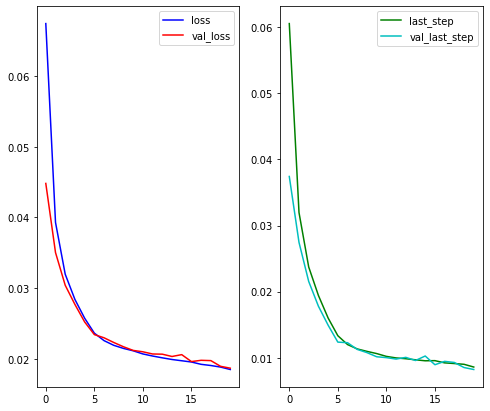

In [51]:
import matplotlib.pyplot as plt
plt.figure(figsize = (8,7))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], 'b-',label = 'loss')
plt.plot(history.history['val_loss'], 'r-', label = 'val_loss')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['last_time_step_mse'], 'g-', label = 'last_step')
plt.plot(history.history['val_last_time_step_mse'], 'c-', label = 'val_last_step')
plt.legend()
plt.show()

3. WaveNet
- 합성곱 신경망을 이용하면 downsampling이 된다는 장점을 활용한 것이다.
- 이 네트워크는 층마다 각 뉴런의 입력이 떨어져 있는 간격인 팽챙 비율을 두배로 늘리는 1D 합성곱 층을 계속 쌓는다.
    - 이렇게 하면 처음에는 2개의 time step을, 다음에는 4개의 time step을, 그 다음에는 8개의 time step을 바라보게 되는 형식이다.
- 이와 같은 network로 **하위층은 단기 패턴을 학습하고 상위 층은 장기 패턴을 학습하게 된다**
- for문 안의 첫번째 층에만 input_shape를 넣는 것보다는 처음부터 명시적으로 Input Layer을 사용하는 것이다.

- padding = 'casual'이라는 것은  ```"causal" results in causal (dilated) convolutions, e.g. output[t] does not depend on input[t+1:]. Useful when modeling temporal data where the model should not violate the temporal order.```
를 보면 이해가 가능하다.
    - 이렇게 하면 합성곱 층이 예측을 만들 때 미래의 sequence를 볼 수 있게 된다. (입력의 왼쪽에 0을 알맞게 padding 하고 padding = 'valid'로 설정하는 것과 마찬가지이다.)
    - 층에 추가하는 padding때문에 모든 합성곱 층은 입력 sequence의 길이와 동일한 sequence를 출력하기 때문에 훈련 내내 전체 sequence를 target으로 훈련이 가능하다.  

**마지막 출력층은 활성화 함수가 없는 합성곱 층인데, 이는 우리가 예측하고자 하는 timestep의 길이만큼 filter을 추가해 주면 된다.**

In [55]:
model = tf.keras.models.Sequential()
model.add(tf.keras.layers.InputLayer(input_shape = [None,1]))
for rate in(1,2,4,8)*2:
    model.add(tf.keras.layers.Conv1D(filters = 20, kernel_size = 2, padding = 'causal', activation = 'relu', dilation_rate = rate))
model.add(tf.keras.layers.Conv1D(filters = 10, kernel_size = 1))
model.summary()
model.compile(loss = 'mse', optimizer = 'adam', metrics = [last_time_step_mse, 'accuracy'])

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_11 (Conv1D)           (None, None, 20)          60        
_________________________________________________________________
conv1d_12 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_13 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_14 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_15 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, None, 20)          820       
_________________________________________________________________
conv1d_17 (Conv1D)           (None, None, 20)        

In [56]:
history = model.fit(x_train, y_train, validation_data = (x_val, y_val), epochs = 20)

Train on 7000 samples, validate on 2000 samples
Epoch 1/20
7000/7000 [==============================] - 3s 400us/sample - loss: 0.0689 - last_time_step_mse: 0.0563 - accuracy: 0.3653 - val_loss: 0.0378 - val_last_time_step_mse: 0.0237 - val_accuracy: 0.5159
Epoch 2/20
7000/7000 [==============================] - 1s 212us/sample - loss: 0.0332 - last_time_step_mse: 0.0202 - accuracy: 0.5200 - val_loss: 0.0307 - val_last_time_step_mse: 0.0178 - val_accuracy: 0.5285
Epoch 3/20
7000/7000 [==============================] - 1s 212us/sample - loss: 0.0289 - last_time_step_mse: 0.0167 - accuracy: 0.5382 - val_loss: 0.0279 - val_last_time_step_mse: 0.0156 - val_accuracy: 0.5364
Epoch 4/20
7000/7000 [==============================] - 1s 213us/sample - loss: 0.0269 - last_time_step_mse: 0.0151 - accuracy: 0.5484 - val_loss: 0.0270 - val_last_time_step_mse: 0.0157 - val_accuracy: 0.5580
Epoch 5/20
7000/7000 [==============================] - 2s 217us/sample - loss: 0.0255 - last_time_step_mse: 0.0

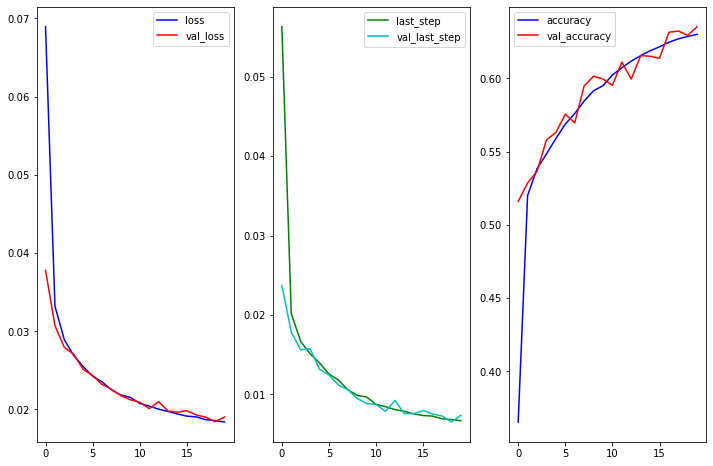

In [59]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12,8))
plt.subplot(1,3,1)
plt.plot(history.history['loss'], 'b-',label = 'loss')
plt.plot(history.history['val_loss'], 'r-', label = 'val_loss')
plt.legend()
plt.subplot(1,3,2)
plt.plot(history.history['last_time_step_mse'], 'g-', label = 'last_step')
plt.plot(history.history['val_last_time_step_mse'], 'c-', label = 'val_last_step')
plt.legend()
plt.subplot(1,3,3)
plt.plot(history.history['accuracy'], 'b-', label = 'accuracy')
plt.plot(history.history['val_accuracy'], 'r-', label = 'val_accuracy')
plt.legend()
plt.show()